In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
# Read
df = pd.read_csv('results.csv', sep=', ', engine='python')
df = df.drop(columns=['Submit datetime', 'Nodes type', 'Queue type'])

# Preprocess 'Real time'
df['Real time'] /= 60
df = df.replace({np.inf: 10.})
df = df.rename(columns={'Real time': 'Real time [m]'})

# Preprocess 'Input' file names
df['Input'] = df['Input'].apply(lambda x: x.split('/')[-1].replace('graf', 'graph'))

# Preprocess '#Threads'
df.loc[df['Solver type'] == 'sequential', '#Threads'] = \
    df.loc[df['Solver type'] == 'sequential', '#Threads'].fillna(1)
df.loc[df['Solver type'] == 'distributed', '#Threads'] = \
    df.loc[df['Solver type'] == 'distributed', '#Threads'].fillna(10)

# Preprocess 'Solver type'
df.loc[df['Sort'] == 'sort', 'Solver type'] += ' (sorted)'
df.drop(columns=['Sort'], inplace=True)

# Calculate acceleration (sequential time divided by parallel time)
def acceleration(row):
    return float(df[(df['Solver type'] == 'sequential') & (df['Input'] == row['Input'])]['Real time [m]']) \
           / row['Real time [m]']
df['Acceleration'] = df.apply(acceleration, axis=1)

df.sample(5)

,Solver type,#CPUs,Input,#Threads,Real time [m],Acceleration
49,distributed,4,graph-t_AD-n_15-k_7-w100_200__b.txt,20.0,0.432067,11.735689
64,task-parallel,1,graph-t_AD-n_15-k_7__b.txt,2.0,5.459817,1.122846
132,data-parallel,1,graph-t_AD-n_18-k_6-w80_100__b.txt,16.0,0.848133,11.299894
32,distributed,2,graph-t_AD-n_15-k_7__b.txt,10.0,10.000000,0.613053
59,distributed,2,graph-t_AD-n_18-k_6-w80_100__a.txt,20.0,10.000000,0.464943


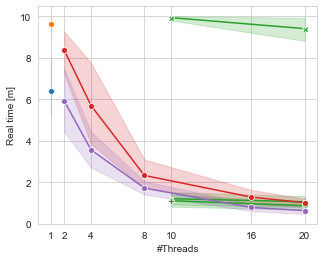

In [3]:
plt.figure(figsize=(5, 4))
sns.lineplot(
    data=df,
    x='#Threads', y='Real time [m]', hue='Solver type', style='#CPUs',
    markers=True, dashes=False, legend=False
)
plt.xticks(df['#Threads'].dropna().unique())
plt.savefig('running-time.pdf', bbox_inches='tight')
plt.show()

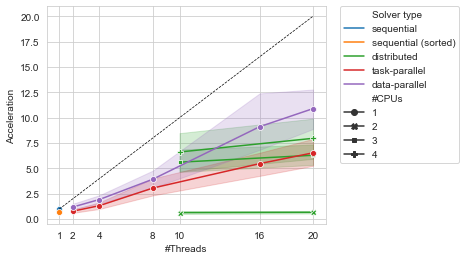

In [4]:
plt.figure(figsize=(5, 4))
sns.lineplot(
    data=df,
    x='#Threads', y='Acceleration', hue='Solver type', style='#CPUs',
    markers=True, dashes=False
)
# plt.plot([2, 20], [0, 20], '--k', linewidth=.7)
plt.plot([1, 20], [1, 20], '--k', linewidth=.7)
plt.xticks(df['#Threads'].dropna().unique())
legend = plt.gca().legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('acceleration.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()